In [1]:
from skimage.draw import ellipse
import numpy as np

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Make sure that random seed is fixed:

In [2]:
np.random.seed(42)

import os
os.environ['PYTHONHASHSEED'] = '42'

import random as rn

rn.seed(42)

import tensorflow as tf

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf = tf.ConfigProto()

from keras import backend as K

tf.set_random_seed(42)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# Detecting the position of a single ellipse on a noisy background

Define the parameters of the synthetic data-set:

In [3]:
picture_size = 50
picture_channels = 3
evidence_size = 500

Generate one solid ellipse on a random background per image:

In [192]:
data_evidence = np.random.rand(evidence_size, picture_size,picture_size, picture_channels)
data_hypotheses_model = np.concatenate((np.random.randint(0,high=picture_size, size=(evidence_size,2)), # position
                                  np.random.rand(evidence_size,2)*6+3,                            # radiuses
                                  np.random.rand(evidence_size,1)*4,                              # rotation
                                  np.random.rand(evidence_size, 3)                                # color
                                 ), axis=1)

def draw_ellipse(data_m, h_model_m):
    data_m_copy = data_m.copy()
    ellipse_cords = ellipse(h_model_m[0], h_model_m[1], h_model_m[2], h_model_m[3],
       shape=(picture_size,picture_size),
       rotation=h_model_m[4])
    
    data_m_copy[ellipse_cords[0], ellipse_cords[1]] = h_model_m[5:8]
    
    return data_m_copy

v_draw_ellipses = np.vectorize(draw_ellipse, signature='(n,n,m),(k)->(n,n,m)')
data_evidence = v_draw_ellipses(data_evidence, data_hypotheses_model)

# only using position as ground-truth to recover with the DL model
data_hypotheses=data_hypotheses_model[:,0:2].astype(int)

onehot_hypotheses = np.zeros((evidence_size,picture_size,picture_size,1))
onehot_hypotheses[np.arange(0,evidence_size), data_hypotheses[:,0], data_hypotheses[:,1],0] = 1

evidence_train, evidence_test, hypotheses_train, hypotheses_test, onehot_hypotheses_train, onehot_hypotheses_test = train_test_split(data_evidence, data_hypotheses, onehot_hypotheses, test_size=0.4)

to_pack = (
    'picture_size',
    'picture_channels',
    'evidence_train',
    'evidence_test',
    'hypotheses_train',
    'hypotheses_test',
    'onehot_hypotheses_train',
    'onehot_hypotheses_test',
)
solid_data = dict()
for i in to_pack:
    solid_data[i] = locals()[i]
    del locals()[i]

This is the shape of our data:

In [194]:
print(solid_data['evidence_train'].shape)
print(solid_data['hypotheses_train'].shape)
print(solid_data['onehot_hypotheses_train'].shape)

(300, 50, 50, 3)
(300, 2)
(300, 50, 50, 1)


This is how one sample from our synthetic data-set looks:

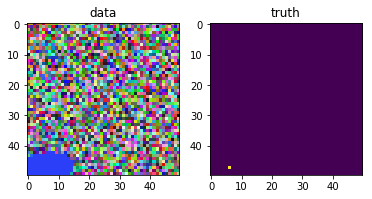

In [195]:
sample_idx = 1
fig1, ax1 = plt.subplots()
fig1.add_subplot(121).imshow(solid_data['evidence_train'][sample_idx,:,:,:])
plt.subplot(121).set_title('data')
fig1.add_subplot(122).imshow(solid_data['onehot_hypotheses_train'][sample_idx,:,:,0])
plt.subplot(122).set_title('truth')

Building Keras model.

In [234]:
from keras.layers import Conv2D, Input, BatchNormalization
from keras.models import Model

solid_input = Input(shape=(picture_size, picture_size, picture_channels), name='solid_input')
solid_model = Model(outputs=Conv2D(1, 5, padding="same", activation='sigmoid', name='solid_conv2')(
                            BatchNormalization(name='solid_bn1')(
                            Conv2D(2, 5, padding="same", activation='relu', name='solid_conv1')(
                            solid_input))),
                    inputs= solid_input)

print(solid_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
solid_input (InputLayer)     (None, 50, 50, 3)         0         
_________________________________________________________________
solid_conv1 (Conv2D)         (None, 50, 50, 2)         152       
_________________________________________________________________
solid_bn1 (BatchNormalizatio (None, 50, 50, 2)         8         
_________________________________________________________________
solid_conv2 (Conv2D)         (None, 50, 50, 1)         51        
Total params: 211
Trainable params: 207
Non-trainable params: 4
_________________________________________________________________
None


As expected, predictions made by an untrained model are useless:

In [236]:
solid_hypotheses_predicted = solid_model.predict_on_batch(solid_data['evidence_test'])

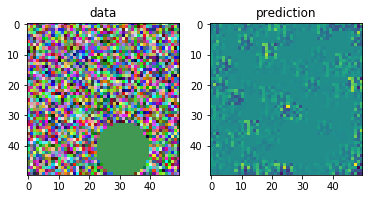

In [237]:
sample_idx = 3
fig2, ax1 = plt.subplots()
fig2.add_subplot(121).imshow(solid_data['evidence_test'][sample_idx,:,:,:])
plt.subplot(121).set_title('data')
fig2.add_subplot(122).imshow(solid_hypotheses_predicted[sample_idx,:,:,0])
plt.subplot(122).set_title('prediction')

Let's train for a 100 epochs:

In [18]:
import numpy.linalg as LA
from scipy import stats
def argmax_distance_metric(predicted, true):
    distances = LA.norm(
        np.array(np.unravel_index(
            np.argmax(predicted.reshape(predicted.shape[0],-1), axis=1),
            (predicted.shape[1], predicted.shape[2])
        )).transpose() -
        true.reshape((true.shape[0], -1)),
        axis=1)
    #return stats.describe(distances)
    return distances.mean()

In [4]:
from keras.callbacks import Callback

class PerformanceCallback(Callback):
    def __init__(self):
        self.best = None
        
    def custom_metric(self):
        return None
    
    def on_epoch_end(self, epoch, logs={}):
        self.last = self.custom_metric()
        
        if ((epoch==0) or (self.last < self.best)):
            self.best = self.last
            self.model.save('../models/checkpoint-%s-%s-%s.h5' % (self.model.name, len(self.model.layers), self.best))


In [261]:
class SolidEllipsesCallback(PerformanceCallback):
    def custom_metric(self):
        hypotheses_predicted = self.model.predict_on_batch(solid_data['evidence_test'])
        result = argmax_distance_metric(hypotheses_predicted, solid_data['hypotheses_test'])
        print("\nargmax_distance_metric after epoch: %s\n" % result) 
        return result

In [228]:
from hyperdash import monitor_cell

In [262]:
%%time
solid_model.compile(optimizer='adam',
              loss='binary_crossentropy')
solid_cb = SolidEllipsesCallback()
def solid_fit():
    solid_model.fit(solid_data['evidence_train'],
                    solid_data['onehot_hypotheses_train'],
                    epochs=100,
                    batch_size=8,
                    callbacks=[solid_cb])
#solid_fit()
#solid_model.save('../models/solid_model-%s-%s.h5' % (len(solid_model.layers), solid_cb.last))

Wall time: 91.5 ms


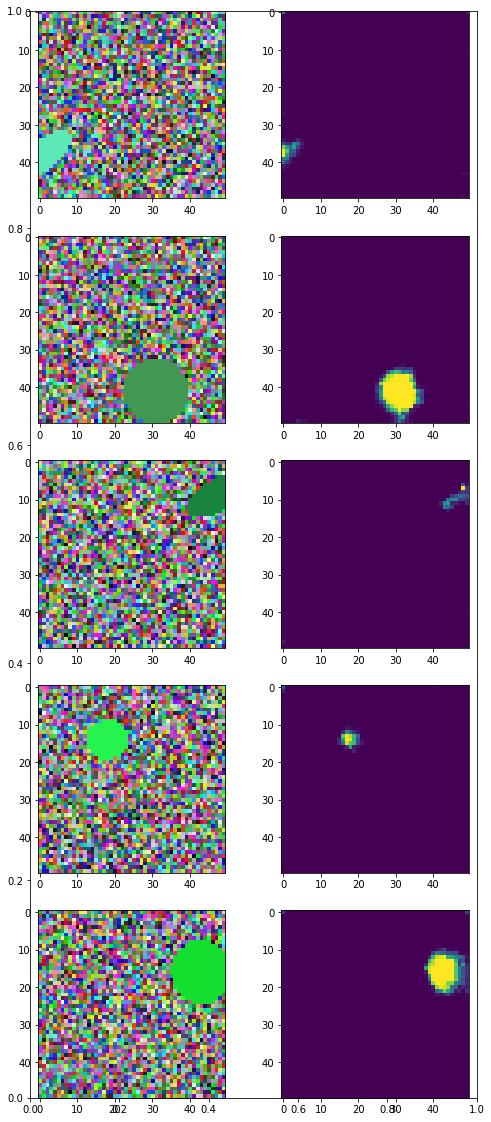

In [217]:
solid_hypotheses_predicted = solid_model.predict_on_batch(solid_data['evidence_test'])
fig3, ax = plt.subplots()
cv_samples_to_plot = 5
fig3.set_size_inches(8, 4*cv_samples_to_plot)
fig_x = 1
for i in np.random.randint(0, solid_data['evidence_test'].shape[0], cv_samples_to_plot):
    fig3.add_subplot(cv_samples_to_plot, 2, fig_x).imshow(solid_data['evidence_test'][i,:,:,:])
    fig3.add_subplot(cv_samples_to_plot, 2, fig_x+1).imshow(solid_hypotheses_predicted[i,:,:,0])
    fig_x = fig_x+2

Let's empiritcally evaluate how stable the architecture is:

In [16]:
from keras import backend as K
def reinit_model(model):
    # from: https://github.com/fchollet/keras/issues/341#issuecomment-319780851
    session = K.get_session()
    for layer in model.layers: 
         for v in layer.__dict__:
             v_arg = getattr(layer,v)
             if hasattr(v_arg,'initializer'):
                 initializer_method = getattr(v_arg, 'initializer')
                 initializer_method.run(session=session)
                 #print('reinitializing layer {}.{}'.format(layer.name, v))

In [240]:
distances = list()
for i in range(0,5):
    reinit_model(solid_model)
    solid_fit()
    distances.append({
        'last': solid_cb.last,
        'best': solid_cb.best,
    })
    
print(distances)

Epoch 1/100
296/300 [============================>.] - ETA: 0s - loss: 0.7339
argmax_distance_metric after epoch: 25.666812559

300/300 [==============================] - 3s - loss: 0.7332     
Epoch 2/100
296/300 [============================>.] - ETA: 0s - loss: 0.6172
argmax_distance_metric after epoch: 33.9133855698

300/300 [==============================] - 0s - loss: 0.6164     
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: 0.4840
argmax_distance_metric after epoch: 33.7356022928

300/300 [==============================] - 0s - loss: 0.4829     
Epoch 4/100
296/300 [============================>.] - ETA: 0s - loss: 0.3234
argmax_distance_metric after epoch: 32.9255080393

300/300 [==============================] - 0s - loss: 0.3224     
Epoch 5/100
296/300 [============================>.] - ETA: 0s - loss: 0.1902
argmax_distance_metric after epoch: 35.0906840081

300/300 [==============================] - 0s - loss: 0.1896     
Epoch 6/100
296/300 [=====

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 85/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 12.8736397727

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 86/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 10.2070560844

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 87/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 12.062164528

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 88/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 11.3308010749

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 89/100
296/300 [============================>.] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 11.8152149058

300/300 [============

300/300 [==============================] - 0s - loss: 0.0034     
Epoch 27/100
296/300 [============================>.] - ETA: 0s - loss: 0.0033
argmax_distance_metric after epoch: 37.0202711788

300/300 [==============================] - 0s - loss: 0.0033     
Epoch 28/100
296/300 [============================>.] - ETA: 0s - loss: 0.0033
argmax_distance_metric after epoch: 37.0801372705

300/300 [==============================] - 0s - loss: 0.0033     
Epoch 29/100
296/300 [============================>.] - ETA: 0s - loss: 0.0033
argmax_distance_metric after epoch: 36.8412614099

300/300 [==============================] - 0s - loss: 0.0033     
Epoch 30/100
296/300 [============================>.] - ETA: 0s - loss: 0.0033
argmax_distance_metric after epoch: 36.8232984529

300/300 [==============================] - 0s - loss: 0.0033     
Epoch 31/100
296/300 [============================>.] - ETA: 0s - loss: 0.0033
argmax_distance_metric after epoch: 36.8640089814

300/300 [===========

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 69/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0025- ETA: 0s - l
argmax_distance_metric after epoch: 27.1173207708

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 70/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 25.5219365593

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 71/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 24.1706701282

300/300 [==============================] - 0s - loss: 0.0024     
Epoch 72/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 22.9172888878

300/300 [==============================] - 0s - loss: 0.0024     
Epoch 73/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 21.4143808584

300/300

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 52/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 27.1967814812

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 53/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 26.1503923382

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 54/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 25.8325433259

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 55/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 26.158998103

300/300 [==============================] - 0s - loss: 0.0025     
Epoch 56/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 24.4680590777

300/300 [============

300/300 [==============================] - 0s - loss: 0.0022     
Epoch 94/100
296/300 [============================>.] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 12.8905763067

300/300 [==============================] - 0s - loss: 0.0022     
Epoch 95/100
296/300 [============================>.] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 13.825057664

300/300 [==============================] - 0s - loss: 0.0022     
Epoch 96/100
296/300 [============================>.] - ETA: 0s - loss: 0.0021
argmax_distance_metric after epoch: 13.2545320479

300/300 [==============================] - 0s - loss: 0.0021     
Epoch 97/100
296/300 [============================>.] - ETA: 0s - loss: 0.0021
argmax_distance_metric after epoch: 13.4072480617

300/300 [==============================] - 0s - loss: 0.0021     
Epoch 98/100
296/300 [============================>.] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 14.75580893

300/300 [==============

300/300 [==============================] - 0s - loss: 0.0040     
Epoch 77/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.2778635257

300/300 [==============================] - 0s - loss: 0.0040     
Epoch 78/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0040
argmax_distance_metric after epoch: 37.2778635257

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 79/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.2778635257

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 80/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.2778635257

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 81/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.2778635257

300/300 [===========

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 60/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 10.1056959955

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 61/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 13.6544929185

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 62/100
296/300 [============================>.] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 9.14895773058

300/300 [==============================] - 0s - loss: 0.0022     
Epoch 63/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 12.6440733719

300/300 [==============================] - 0s - loss: 0.0022     
Epoch 64/100
296/300 [============================>.] - ETA: 0s - loss: 0.0022
argmax_distance_metric after epoch: 10.2921425359

300/300 [===========

In [162]:
smooth = 0.001

def dice_coef_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return -(2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

We will also monitor validation loss, which is now intuitive: Dice coefficient is always between `0` and `2`.

In [242]:
%%time
solid_model.compile(optimizer='adam',
              loss=dice_coef_loss)
def solid_fit_dice():
    solid_model.fit(solid_data['evidence_train'],
                    solid_data['onehot_hypotheses_train'],
                    epochs=100,
                    batch_size=8,
                    callbacks=[solid_cb])


Wall time: 94 ms


In [263]:
distances = list()
for i in range(0,5):
    reinit_model(solid_model)
    solid_fit_dice()
    distances.append({
        'last': solid_cb.last,
        'best': solid_cb.best,
    })
    
print(distances)

Epoch 1/100
296/300 [============================>.] - ETA: 0s - loss: 0.7567
argmax_distance_metric after epoch: 32.0414464432

300/300 [==============================] - 3s - loss: 0.7557     
Epoch 2/100
288/300 [===========================>..] - ETA: 0s - loss: 0.6220
argmax_distance_metric after epoch: 32.9415372105

300/300 [==============================] - 0s - loss: 0.6192     
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: 0.4656
argmax_distance_metric after epoch: 34.1032531326

300/300 [==============================] - 0s - loss: 0.4645     
Epoch 4/100
288/300 [===========================>..] - ETA: 0s - loss: 0.3102
argmax_distance_metric after epoch: 32.6718186539

300/300 [==============================] - 0s - loss: 0.3074     
Epoch 5/100
288/300 [===========================>..] - ETA: 0s - loss: 0.1896
argmax_distance_metric after epoch: 32.5895627457

300/300 [==============================] - 0s - loss: 0.1877     
Epoch 6/100
296/300 [====

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 43/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 35.2763790252

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 44/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 35.2683766467

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 45/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 35.018499508

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 46/100
296/300 [============================>.] - ETA: 0s - loss: 0.0027
argmax_distance_metric after epoch: 35.7025714336

300/300 [==============================] - 0s - loss: 0.0027     
Epoch 47/100
296/300 [============================>.] - ETA: 0s - loss: 0.0027
argmax_distance_metric after epoch: 35.0508364453

300/300 [============

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 85/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 22.5862101984

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 86/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 21.2245567442

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 87/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 20.4445745207

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 88/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 19.661205372

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 89/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 20.1420625747

300/300 [============

300/300 [==============================] - 0s - loss: 0.0029     
Epoch 27/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 36.4085234119

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 28/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 36.5350095369

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 29/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 36.4742324719

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 30/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 36.0781020276

300/300 [==============================] - 0s - loss: 0.0028     
Epoch 31/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 36.0781020276

300/300 [===========

300/300 [==============================] - 0s - loss: 0.0024     
Epoch 69/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 17.2994945465

300/300 [==============================] - 0s - loss: 0.0024     
Epoch 70/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 17.3517121488

300/300 [==============================] - 0s - loss: 0.0024     
Epoch 71/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 17.8284625541

300/300 [==============================] - 0s - loss: 0.0024     
Epoch 72/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023- ETA: 0s - l
argmax_distance_metric after epoch: 17.8960064979

300/300 [==============================] - 0s - loss: 0.0023     
Epoch 73/100
296/300 [============================>.] - ETA: 0s - loss: 0.0023
argmax_distance_metric after epoch: 18.1238952728

300/300

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 52/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.4708179365

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 53/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.4708179365

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 54/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.4708179365

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 55/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.4708179365

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 56/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.4708179365

300/300 [===========

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 94/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.3143530323

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 95/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.3143530323

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 96/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.3143530323

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 97/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.3143530323

300/300 [==============================] - 0s - loss: 0.0039     
Epoch 98/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 38.3143530323

300/300 [===========

300/300 [==============================] - 0s - loss: 0.0045     
Epoch 36/100
296/300 [============================>.] - ETA: 0s - loss: 0.0045
argmax_distance_metric after epoch: 35.3411970391

300/300 [==============================] - 0s - loss: 0.0044     
Epoch 37/100
296/300 [============================>.] - ETA: 0s - loss: 0.0044
argmax_distance_metric after epoch: 35.3442096179

300/300 [==============================] - 0s - loss: 0.0044     
Epoch 38/100
296/300 [============================>.] - ETA: 0s - loss: 0.0044
argmax_distance_metric after epoch: 35.4558667764

300/300 [==============================] - 0s - loss: 0.0044     
Epoch 39/100
296/300 [============================>.] - ETA: 0s - loss: 0.0043
argmax_distance_metric after epoch: 35.4549466001

300/300 [==============================] - 0s - loss: 0.0043     
Epoch 40/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0043
argmax_distance_metric after epoch: 35.4479420492

300/300 [===========

300/300 [==============================] - 0s - loss: 0.0042     
Epoch 19/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
argmax_distance_metric after epoch: 38.4232939257

300/300 [==============================] - 0s - loss: 0.0041     
Epoch 20/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
argmax_distance_metric after epoch: 38.4232939257

300/300 [==============================] - 0s - loss: 0.0041     
Epoch 21/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
argmax_distance_metric after epoch: 38.4232939257

300/300 [==============================] - 0s - loss: 0.0041     
Epoch 22/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
argmax_distance_metric after epoch: 38.4232939257

300/300 [==============================] - 0s - loss: 0.0041     
Epoch 23/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
argmax_distance_metric after epoch: 38.4232939257

300/300 [===========

# Hollow Ellipse

In [247]:
data_evidence = np.random.rand(evidence_size, picture_size,picture_size, picture_channels)
data_hypotheses_model = np.concatenate((np.random.randint(0,high=picture_size, size=(evidence_size,2)), # position
                                  np.random.rand(evidence_size,2)*6+3,                            # radiuses
                                  np.random.rand(evidence_size,1)*4,                              # rotation
                                  np.random.rand(evidence_size, 3)                                # color
                                 ), axis=1)

def draw_ellipse(data_m, h_model_m):
    data_m_copy = data_m.copy()
    ellipse_cords = ellipse(h_model_m[0], h_model_m[1], h_model_m[2], h_model_m[3],
       shape=(picture_size,picture_size),
       rotation=h_model_m[4])
    
    eellipse_cords = ellipse(h_model_m[0], h_model_m[1], h_model_m[2]*0.5, h_model_m[3]*0.5,
       shape=(picture_size,picture_size),
       rotation=h_model_m[4])
    
    data_m_copy[ellipse_cords[0], ellipse_cords[1]] = h_model_m[5:8]
    data_m_copy[eellipse_cords[0], eellipse_cords[1]] = data_m[eellipse_cords[0], eellipse_cords[1]]
    
    return data_m_copy

v_draw_ellipses = np.vectorize(draw_ellipse, signature='(n,n,m),(k)->(n,n,m)')
data_evidence = v_draw_ellipses(data_evidence, data_hypotheses_model)

# only using position as ground-truth to recover with the DL model
data_hypotheses=data_hypotheses_model[:,0:2].astype(int)

onehot_hypotheses = np.zeros((evidence_size,picture_size,picture_size,1))
onehot_hypotheses[np.arange(0,evidence_size), data_hypotheses[:,0], data_hypotheses[:,1],0] = 1

evidence_train, evidence_test, hypotheses_train, hypotheses_test, onehot_hypotheses_train, onehot_hypotheses_test = train_test_split(data_evidence, data_hypotheses, onehot_hypotheses, test_size=0.4)

to_pack = (
    'picture_size',
    'picture_channels',
    'evidence_train',
    'evidence_test',
    'hypotheses_train',
    'hypotheses_test',
    'onehot_hypotheses_train',
    'onehot_hypotheses_test',
)
empty_data = dict()
for i in to_pack:
    empty_data[i] = locals()[i]
    del locals()[i]

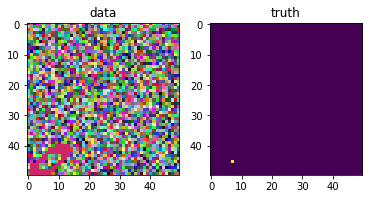

In [248]:
sample_idx = 1

fig1, ax1 = plt.subplots()
fig1.add_subplot(121).imshow(empty_data['evidence_train'][sample_idx,:,:,:])
plt.subplot(121).set_title('data')
fig1.add_subplot(122).imshow(empty_data['onehot_hypotheses_train'][sample_idx,:,:,0])
plt.subplot(122).set_title('truth')

In [264]:
class EmptyEllipsesCallback(PerformanceCallback):
    def custom_metric(self):
        hypotheses_predicted = self.model.predict_on_batch(empty_data['evidence_test'])
        result = argmax_distance_metric(hypotheses_predicted, empty_data['hypotheses_test'])
        print("\nargmax_distance_metric after epoch: %s\n" % result) 
        return result

In [267]:
empty_input = Input(shape=(picture_size, picture_size, picture_channels), name='empty')
empty_model = Model(outputs=Conv2D(1, 5, padding="same", activation='sigmoid', name='empty_conv2')(
                            BatchNormalization(name='empty_bn1')(
                            Conv2D(2, 5, padding="same", activation='relu', name='empty_conv1')(
                            empty_input))),
                    inputs= empty_input)

print(empty_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty (InputLayer)           (None, 50, 50, 3)         0         
_________________________________________________________________
empty_conv1 (Conv2D)         (None, 50, 50, 2)         152       
_________________________________________________________________
empty_bn1 (BatchNormalizatio (None, 50, 50, 2)         8         
_________________________________________________________________
empty_conv2 (Conv2D)         (None, 50, 50, 1)         51        
Total params: 211
Trainable params: 207
Non-trainable params: 4
_________________________________________________________________
None


In [268]:
empty_model.compile(optimizer='adam',
              loss='binary_crossentropy')
empty_cb = EmptyEllipsesCallback()
def empty_fit():
    empty_model.fit(empty_data['evidence_train'],
                    empty_data['onehot_hypotheses_train'],
                    epochs=100,
                    batch_size=8,
                    callbacks=[empty_cb],
                    validation_data=(empty_data['evidence_test'], empty_data['onehot_hypotheses_test']))

In [269]:
distances = list()
for i in range(0,5):
    reinit_model(empty_model)
    empty_fit()
    distances.append({
        'last': empty_cb.last,
        'best': empty_cb.best,
    })
    
print(distances)

Train on 300 samples, validate on 200 samples
Epoch 1/100
296/300 [============================>.] - ETA: 0s - loss: 0.7197
argmax_distance_metric after epoch: 33.4393456113

300/300 [==============================] - 3s - loss: 0.7187 - val_loss: 0.6454
Epoch 2/100
296/300 [============================>.] - ETA: 0s - loss: 0.5875
argmax_distance_metric after epoch: 35.7887222701

300/300 [==============================] - 0s - loss: 0.5865 - val_loss: 0.5117
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: 0.4171
argmax_distance_metric after epoch: 36.1412629309

300/300 [==============================] - 0s - loss: 0.4158 - val_loss: 0.3198
Epoch 4/100
296/300 [============================>.] - ETA: 0s - loss: 0.2408
argmax_distance_metric after epoch: 36.1412629309

300/300 [==============================] - 0s - loss: 0.2399 - val_loss: 0.1735
Epoch 5/100
296/300 [============================>.] - ETA: 0s - loss: 0.1308
argmax_distance_metric after epoch: 36.1

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0040
Epoch 79/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 36.8082033251

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0040
Epoch 80/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 36.8545292808

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 81/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 36.9229324127

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 82/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.2010443546

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 83/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
a

300/300 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0045
Epoch 18/100
296/300 [============================>.] - ETA: 0s - loss: 0.0045
argmax_distance_metric after epoch: 35.0058037585

300/300 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0044
Epoch 19/100
296/300 [============================>.] - ETA: 0s - loss: 0.0044
argmax_distance_metric after epoch: 35.4523757769

300/300 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0043
Epoch 20/100
296/300 [============================>.] - ETA: 0s - loss: 0.0043
argmax_distance_metric after epoch: 35.5929240129

300/300 [==============================] - 0s - loss: 0.0043 - val_loss: 0.0043
Epoch 21/100
296/300 [============================>.] - ETA: 0s - loss: 0.0043
argmax_distance_metric after epoch: 35.5929240129

300/300 [==============================] - 1s - loss: 0.0043 - val_loss: 0.0042
Epoch 22/100
296/300 [============================>.] - ETA: 0s - loss: 0.0042
a

300/300 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 96/100
296/300 [============================>.] - ETA: 0s - loss: 0.0036
argmax_distance_metric after epoch: 33.0701481526

300/300 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 97/100
296/300 [============================>.] - ETA: 0s - loss: 0.0036
argmax_distance_metric after epoch: 33.224146505

300/300 [==============================] - 1s - loss: 0.0036 - val_loss: 0.0036
Epoch 98/100
296/300 [============================>.] - ETA: 0s - loss: 0.0036
argmax_distance_metric after epoch: 33.217228262

300/300 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 99/100
296/300 [============================>.] - ETA: 0s - loss: 0.0036
argmax_distance_metric after epoch: 33.0420317121

300/300 [==============================] - 0s - loss: 0.0036 - val_loss: 0.0036
Epoch 100/100
296/300 [============================>.] - ETA: 0s - loss: 0.0036
ar

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 74/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 39.347413497

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 75/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 39.347413497

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 76/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 39.347413497

300/300 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0039
Epoch 77/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 39.347413497

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 78/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argma

300/300 [==============================] - 0s - loss: 0.0049 - val_loss: 0.0050
Epoch 13/100
296/300 [============================>.] - ETA: 0s - loss: 0.0048
argmax_distance_metric after epoch: 36.9801561631

300/300 [==============================] - 0s - loss: 0.0048 - val_loss: 0.0049
Epoch 14/100
296/300 [============================>.] - ETA: 0s - loss: 0.0047
argmax_distance_metric after epoch: 36.9801561631

300/300 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0048
Epoch 15/100
296/300 [============================>.] - ETA: 0s - loss: 0.0046
argmax_distance_metric after epoch: 36.9801561631

300/300 [==============================] - 0s - loss: 0.0046 - val_loss: 0.0047
Epoch 16/100
296/300 [============================>.] - ETA: 0s - loss: 0.0045
argmax_distance_metric after epoch: 36.9801561631

300/300 [==============================] - 0s - loss: 0.0045 - val_loss: 0.0047
Epoch 17/100
296/300 [============================>.] - ETA: 0s - loss: 0.0045
a

300/300 [==============================] - 0s - loss: 0.0039 - val_loss: 0.0039
Epoch 91/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.4266809844

300/300 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0039
Epoch 92/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.4266809844

300/300 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0039
Epoch 93/100
280/300 [===========================>..] - ETA: 0s - loss: 0.0039
argmax_distance_metric after epoch: 37.4266809844

300/300 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0039
Epoch 94/100
296/300 [============================>.] - ETA: 0s - loss: 0.0039- ETA: 0s - loss
argmax_distance_metric after epoch: 37.4266809844

300/300 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0039
Epoch 95/100
296/300 [============================>.] - ETA: 0s 

300/300 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0040
Epoch 30/100
296/300 [============================>.] - ETA: 0s - loss: 0.0040
argmax_distance_metric after epoch: 37.2171486686

300/300 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0040
Epoch 31/100
296/300 [============================>.] - ETA: 0s - loss: 0.0040
argmax_distance_metric after epoch: 37.2171486686

300/300 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0040
Epoch 32/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0040
argmax_distance_metric after epoch: 37.2171486686

300/300 [==============================] - 1s - loss: 0.0040 - val_loss: 0.0040
Epoch 33/100
296/300 [============================>.] - ETA: 0s - loss: 0.0040
argmax_distance_metric after epoch: 37.2171486686

300/300 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0040
Epoch 34/100
296/300 [============================>.] - ETA: 0s - loss: 0.0040
a

In [270]:
solid_model = keras.models.load_model('../models/solid_model-4-2.64079098503.h5')
for layer in solid_model.layers:
    layer.trainable=False

In [271]:
empty_input = Input(shape=(picture_size, picture_size, picture_channels), name='empty')
empty_model = Model(outputs=solid_model(
                            Conv2D(3, 5, padding="same", activation='sigmoid', name='empty_conv2')(
                            BatchNormalization(name='empty_bn1')(
                            Conv2D(2, 5, padding="same", activation='relu', name='empty_conv1')(
                            empty_input)))),
                    inputs= empty_input,
                    name='empty-model-with-frozen-solid')

print(empty_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty (InputLayer)           (None, 50, 50, 3)         0         
_________________________________________________________________
empty_conv1 (Conv2D)         (None, 50, 50, 2)         152       
_________________________________________________________________
empty_bn1 (BatchNormalizatio (None, 50, 50, 2)         8         
_________________________________________________________________
empty_conv2 (Conv2D)         (None, 50, 50, 3)         153       
_________________________________________________________________
model_23 (Model)             (None, 50, 50, 1)         211       
Total params: 524
Trainable params: 309
Non-trainable params: 215
_________________________________________________________________
None


In [273]:
empty_model.compile(optimizer='adam',
              loss='binary_crossentropy')

In [275]:
distances = list()
for i in range(0,5):
    reinit_model(empty_model)
    empty_fit()
    distances.append({
        'last': empty_cb.last,
        'best': empty_cb.best,
    })
    empty_model.save('../models/empty-model-w-solid-%s-%s.h5' % (len(empty_model.layers), empty_cb.last))
    
print(distances)

Train on 300 samples, validate on 200 samples
Epoch 1/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0055
argmax_distance_metric after epoch: 32.8373409634

300/300 [==============================] - 1s - loss: 0.0054 - val_loss: 0.0124
Epoch 2/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0049
argmax_distance_metric after epoch: 32.0916087477

300/300 [==============================] - 1s - loss: 0.0049 - val_loss: 0.0072
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: 0.0046
argmax_distance_metric after epoch: 32.1871477576

300/300 [==============================] - 1s - loss: 0.0046 - val_loss: 0.0056
Epoch 4/100
296/300 [============================>.] - ETA: 0s - loss: 0.0045
argmax_distance_metric after epoch: 32.1556480028

300/300 [==============================] - 1s - loss: 0.0045 - val_loss: 0.0049
Epoch 5/100
296/300 [============================>.] - ETA: 0s - loss: 0.0043
argmax_distance_metric after epoch: 31.9

300/300 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0039
Epoch 79/100
296/300 [============================>.] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 21.3948607957

300/300 [==============================] - 2s - loss: 0.0028 - val_loss: 0.0038
Epoch 80/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0028- ETA: 1s 
argmax_distance_metric after epoch: 20.3912339876

300/300 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0040
Epoch 81/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 19.2910711143

300/300 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0038
Epoch 82/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 19.4118631394

300/300 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0038
Epoch 83/100
288/300 [===========================>..] - ETA: 0s - loss

296/300 [============================>.] - ETA: 0s - loss: 0.0030
argmax_distance_metric after epoch: 17.7384096079

300/300 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0039
Epoch 57/100
296/300 [============================>.] - ETA: 0s - loss: 0.0030
argmax_distance_metric after epoch: 15.1126521511

300/300 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0037
Epoch 58/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 15.8846794075

300/300 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0036
Epoch 59/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 14.5303611088

300/300 [==============================] - 1s - loss: 0.0030 - val_loss: 0.0037
Epoch 60/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0030
argmax_distance_metric after epoch: 17.229324461

300/300 [==============================] - 1

296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 17.2109737395

300/300 [==============================] - 3s - loss: 0.0028 - val_loss: 0.0036
Epoch 96/100
296/300 [============================>.] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 16.2077924947

300/300 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0037
Epoch 97/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 16.8978809522

300/300 [==============================] - 1s - loss: 0.0028 - val_loss: 0.0037
Epoch 98/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0028
argmax_distance_metric after epoch: 17.3683517767

300/300 [==============================] - 3s - loss: 0.0028 - val_loss: 0.0038
Epoch 99/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0027
argmax_distance_metric after epoch: 15.0422470389

300/300 [==============================] - 

300/300 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0038
Epoch 73/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 20.2536862514

300/300 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0037
Epoch 74/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 20.0705955896

300/300 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0040
Epoch 75/100
296/300 [============================>.] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 19.6607631436

300/300 [==============================] - 1s - loss: 0.0029 - val_loss: 0.0038
Epoch 76/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0029
argmax_distance_metric after epoch: 19.303144994

300/300 [==============================] - 3s - loss: 0.0029 - val_loss: 0.0038
Epoch 77/100
296/300 [============================>.] - ETA: 0s - loss: 0.0029
ar

300/300 [==============================] - 1s - loss: 0.0043 - val_loss: 0.0040
Epoch 12/100
296/300 [============================>.] - ETA: 0s - loss: 0.0042
argmax_distance_metric after epoch: 24.4269342582

300/300 [==============================] - 1s - loss: 0.0042 - val_loss: 0.0039
Epoch 13/100
296/300 [============================>.] - ETA: 0s - loss: 0.0042
argmax_distance_metric after epoch: 24.0383358014

300/300 [==============================] - 1s - loss: 0.0042 - val_loss: 0.0040
Epoch 14/100
296/300 [============================>.] - ETA: 0s - loss: 0.0042
argmax_distance_metric after epoch: 23.7695624374

300/300 [==============================] - 1s - loss: 0.0042 - val_loss: 0.0040
Epoch 15/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
argmax_distance_metric after epoch: 22.205891665

300/300 [==============================] - 1s - loss: 0.0041 - val_loss: 0.0041
Epoch 16/100
296/300 [============================>.] - ETA: 0s - loss: 0.0041
ar

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0033
Epoch 90/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 18.1162808244

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0034
Epoch 91/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 17.6582499728

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0034
Epoch 92/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 18.1560849401

300/300 [==============================] - 2s - loss: 0.0026 - val_loss: 0.0035
Epoch 93/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 17.8942442187

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0034
Epoch 94/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
a

296/300 [============================>.] - ETA: 0s - loss: 0.0027
argmax_distance_metric after epoch: 18.2138368429

300/300 [==============================] - 1s - loss: 0.0027 - val_loss: 0.0031
Epoch 68/100
296/300 [============================>.] - ETA: 0s - loss: 0.0027
argmax_distance_metric after epoch: 16.7036450022

300/300 [==============================] - 2s - loss: 0.0027 - val_loss: 0.0031
Epoch 69/100
288/300 [===========================>..] - ETA: 0s - loss: 0.0027
argmax_distance_metric after epoch: 18.4156047332

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0031
Epoch 70/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 16.9012145424

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0033
Epoch 71/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 17.2906507634

300/300 [==============================] - 

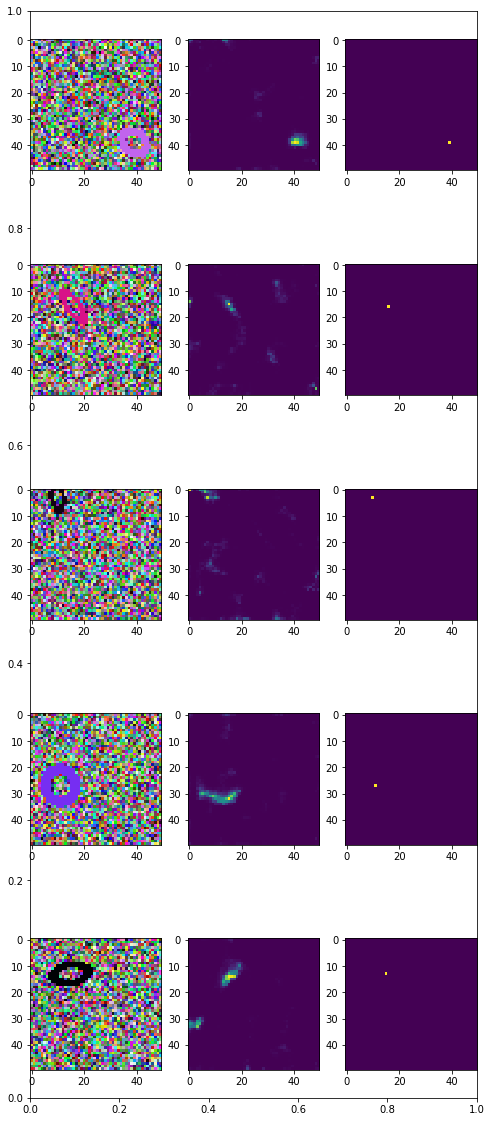

In [303]:
empty_hypotheses_predicted = empty_model.predict_on_batch(empty_data['evidence_test'])
fig5, ax = plt.subplots()
cv_samples_to_plot = 5
fig5.set_size_inches(8, 4*cv_samples_to_plot)
fig_x = 1
for i in np.random.randint(0, empty_data['evidence_test'].shape[0], cv_samples_to_plot):
    fig5.add_subplot(cv_samples_to_plot, 3, fig_x).imshow(empty_data['evidence_test'][i,:,:,:])
    fig5.add_subplot(cv_samples_to_plot, 3, fig_x+1).imshow(empty_hypotheses_predicted[i,:,:,0])
    fig5.add_subplot(cv_samples_to_plot, 3, fig_x+2).imshow(empty_data['onehot_hypotheses_test'][i,:,:,0])
    fig_x = fig_x+3

In [296]:
empty_model = keras.models.load_model('../models/empty-model-w-solid-5-14.6283033477.h5')
empty_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty (InputLayer)           (None, 50, 50, 3)         0         
_________________________________________________________________
empty_conv1 (Conv2D)         (None, 50, 50, 2)         152       
_________________________________________________________________
empty_bn1 (BatchNormalizatio (None, 50, 50, 2)         8         
_________________________________________________________________
empty_conv2 (Conv2D)         (None, 50, 50, 3)         153       
_________________________________________________________________
model_23 (Model)             (None, 50, 50, 1)         211       
Total params: 524
Trainable params: 309
Non-trainable params: 215
_________________________________________________________________


In [299]:
for layer in empty_model.get_layer('model_23').layers:
    layer.trainable=True
empty_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
empty (InputLayer)           (None, 50, 50, 3)         0         
_________________________________________________________________
empty_conv1 (Conv2D)         (None, 50, 50, 2)         152       
_________________________________________________________________
empty_bn1 (BatchNormalizatio (None, 50, 50, 2)         8         
_________________________________________________________________
empty_conv2 (Conv2D)         (None, 50, 50, 3)         153       
_________________________________________________________________
model_23 (Model)             (None, 50, 50, 1)         211       
Total params: 524
Trainable params: 516
Non-trainable params: 8
_________________________________________________________________


In [294]:
#empty_model.compile(optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
#                    loss='binary_crossentropy')

In [300]:
empty_fit()

Train on 300 samples, validate on 200 samples
Epoch 1/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 15.0291526503

300/300 [==============================] - 2s - loss: 0.0025 - val_loss: 0.0033
Epoch 2/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 14.4677320178

300/300 [==============================] - 1s - loss: 0.0025 - val_loss: 0.0032
Epoch 3/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025
argmax_distance_metric after epoch: 15.20302318

300/300 [==============================] - 1s - loss: 0.0025 - val_loss: 0.0031
Epoch 4/100
296/300 [============================>.] - ETA: 0s - loss: 0.0026
argmax_distance_metric after epoch: 15.1101184591

300/300 [==============================] - 1s - loss: 0.0026 - val_loss: 0.0031
Epoch 5/100
296/300 [============================>.] - ETA: 0s - loss: 0.0025- ETA: 0s
argmax_distance_metric after epoc

300/300 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0032
Epoch 79/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 12.4559229207

300/300 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0032
Epoch 80/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 13.2390859928

300/300 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0033
Epoch 81/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 12.8650238611

300/300 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0032
Epoch 82/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
argmax_distance_metric after epoch: 12.1312415293

300/300 [==============================] - 1s - loss: 0.0024 - val_loss: 0.0032
Epoch 83/100
296/300 [============================>.] - ETA: 0s - loss: 0.0024
a

In [304]:
empty_model.save('../models/empty-model-w-solid-fine-tuned-%s-%s.h5' % (len(empty_model.layers), empty_cb.last))

# Moving ellipses

Dataset is taking a while to generate.

In [5]:
import pickle
with open('../../lord-of-the-ring/ellipses_stories_50.pickle', 'rb') as file:
    data = pickle.load(file)

In [2]:
data['evidence_test'].shape

(20, 250, 50, 50, 3)

In [3]:
def gen_animate(evidence, hypothesis, episode):
    def animate(i):
        if evidence.shape[-1] == 1:
            left.imshow(evidence[episode,i,:,:,0])
        else:
            left.imshow(evidence[episode,i,:,:,:])
        right.imshow(hypothesis[episode,i,:,:,0])
    return animate

In [37]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
left = fig.add_subplot(121)
right = fig.add_subplot(122)

ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], data['onehot_hypotheses_test'], 3), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

ValueError: object too deep for desired array

In [4]:
empty_model = keras.models.load_model('../models/empty-model-w-solid-fine-tuned-5-11.8159677888.h5')

NameError: name 'keras' is not defined

This time we can precompute the output of our pre-trained model:

In [357]:
evidence_train_features = empty_model.predict_on_batch(data['evidence_train'].reshape((-1,) + data['evidence_train'].shape[2:])).reshape(data['evidence_train'].shape[:-1] + (1,))

In [121]:
evidence_train_features.shape

(30, 250, 50, 50, 1)

In [358]:
evidence_test_features = empty_model.predict_on_batch(data['evidence_test'].reshape((-1,) + data['evidence_test'].shape[2:])).reshape(data['evidence_test'].shape[:-1] + (1,))

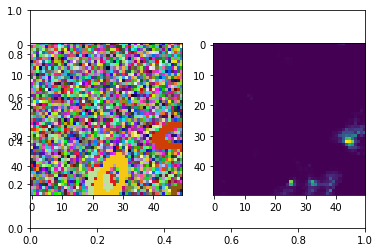

In [312]:
fig, ax = plt.subplots()
left = fig.add_subplot(121)
right = fig.add_subplot(122)

ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], evidence_test_features, 3), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

In [360]:
class MovingFeaturesEllipsesCallback(PerformanceCallback):
    def custom_metric(self):
        hypotheses_predicted = self.model.predict_on_batch(evidence_test_features)
        result = argmax_distance_metric(
            hypotheses_predicted.reshape((-1,) + hypotheses_predicted.shape[2:]),
            data['hypotheses_test'].reshape((-1,) + data['hypotheses_test'].shape[2:]))
        print("\nargmax_distance_metric after epoch: %s\n" % result) 
        return result

In [334]:
from keras.layers import ConvLSTM2D
from keras.layers import TimeDistributed

move_feature_inputs = Input(shape=(None, picture_size, picture_size, 1), name='move_feature_inputs')
move_inputs = Input(shape=(None, picture_size, picture_size, picture_channels), name='move_inputs')

move_features_model = Model(outputs=ConvLSTM2D(1, 10, padding='same', return_sequences=True, name='move_convlstm2d2')(
                                    BatchNormalization(name='move_bN1')(
                                    ConvLSTM2D(1, 10, padding='same', return_sequences=True, name='move_convlstm2d1')(
                                    move_feature_inputs))),
                            inputs= move_feature_inputs,
                            name='move-model-with-features-input')

print(move_features_model.summary())
print(move_features_model.output.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
move_feature_inputs (InputLa (None, None, 50, 50, 1)   0         
_________________________________________________________________
move_convlstm2d1 (ConvLSTM2D (None, None, 50, 50, 1)   804       
_________________________________________________________________
move_bN1 (BatchNormalization (None, None, 50, 50, 1)   4         
_________________________________________________________________
move_convlstm2d2 (ConvLSTM2D (None, None, 50, 50, 1)   804       
Total params: 1,612
Trainable params: 1,610
Non-trainable params: 2
_________________________________________________________________
None
(?, ?, 50, 50, 1)


In [335]:
move_features_model.compile(optimizer='adam',
                            loss='binary_crossentropy')

In [361]:
move_features_cb = MovingFeaturesEllipsesCallback()
def move_features_fit():
    move_features_model.fit(evidence_train_features,
                    data['onehot_hypotheses_train'],
                    epochs=100,
                    batch_size=4,
                    callbacks=[move_features_cb],
                    validation_data=(evidence_test_features, data['onehot_hypotheses_test']))

In [348]:
distances = list()
for i in range(0,4):
    reinit_model(move_features_model)
    move_features_fit()
    distances.append({
        'last': move_features_cb.last,
        'best': move_features_cb.best,
    })
    move_features_model.save('../models/move-features-%s-%s.h5' % (len(move_features_model.layers), move_features_cb.last))
    
print(distances)

Train on 30 samples, validate on 20 samples
Epoch 1/100
28/30 [===========================>..] - ETA: 4s - loss: 0.0309 
argmax_distance_metric after epoch: 25.4012359658

30/30 [==============================] - 83s - loss: 0.0293 - val_loss: 0.0064
Epoch 2/100
28/30 [===========================>..] - ETA: 5s - loss: 0.0059 
argmax_distance_metric after epoch: 35.2726136881

30/30 [==============================] - 100s - loss: 0.0059 - val_loss: 0.0064
Epoch 3/100
28/30 [===========================>..] - ETA: 4s - loss: 0.0060 
argmax_distance_metric after epoch: 35.4334658379

30/30 [==============================] - 83s - loss: 0.0060 - val_loss: 0.0064
Epoch 4/100
28/30 [===========================>..] - ETA: 4s - loss: 0.0061 
argmax_distance_metric after epoch: 35.4348120762

30/30 [==============================] - 82s - loss: 0.0061 - val_loss: 0.0064
Epoch 5/100
28/30 [===========================>..] - ETA: 4s - loss: 0.0060 
argmax_distance_metric after epoch: 34.8627641543


30/30 [==============================] - 74s - loss: 0.0039 - val_loss: 0.0038
Epoch 80/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0040 
argmax_distance_metric after epoch: 19.5070835495

30/30 [==============================] - 74s - loss: 0.0040 - val_loss: 0.0040
Epoch 81/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0039 
argmax_distance_metric after epoch: 19.4943152891

30/30 [==============================] - 74s - loss: 0.0039 - val_loss: 0.0037
Epoch 82/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0039 
argmax_distance_metric after epoch: 19.5333104123

30/30 [==============================] - 74s - loss: 0.0039 - val_loss: 0.0038
Epoch 83/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0038 
argmax_distance_metric after epoch: 19.679661243

30/30 [==============================] - 74s - loss: 0.0038 - val_loss: 0.0038
Epoch 84/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0038 
argmax_dista

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9381355838

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 59/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.8268317585

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 60/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.6921371562

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 61/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.599944564

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 62/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.46108681

30/30 [==============================] - 74s - loss: 0.

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 98/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 31.1064142091

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 99/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 30.9457368573

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 100/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 30.8860675414

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Train on 30 samples, validate on 20 samples
Epoch 1/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0363 
argmax_distance_metric after epoch: 33.1305689451

30/30 [==============================] - 74s - loss: 0.0343 - val_loss: 0.0064
Epoch 2/100
28/30 [==========================

28/30 [===========================>..] - ETA: 3s - loss: 0.0038 
argmax_distance_metric after epoch: 20.0697783537

30/30 [==============================] - 74s - loss: 0.0037 - val_loss: 0.0037
Epoch 77/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0037 
argmax_distance_metric after epoch: 19.5425748241

30/30 [==============================] - 74s - loss: 0.0037 - val_loss: 0.0038
Epoch 78/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0037 
argmax_distance_metric after epoch: 19.4957705082

30/30 [==============================] - 74s - loss: 0.0037 - val_loss: 0.0036
Epoch 79/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0036 
argmax_distance_metric after epoch: 19.633339742

30/30 [==============================] - 74s - loss: 0.0036 - val_loss: 0.0042
Epoch 80/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0037 
argmax_distance_metric after epoch: 19.4292759267

30/30 [==============================] - 74s - loss: 

30/30 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0040
Epoch 55/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0045 
argmax_distance_metric after epoch: 23.5054851184

30/30 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0040
Epoch 56/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0044 
argmax_distance_metric after epoch: 20.7582977879

30/30 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0043
Epoch 57/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0044 
argmax_distance_metric after epoch: 20.1005786257

30/30 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0046
Epoch 58/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0044 
argmax_distance_metric after epoch: 20.0785267161

30/30 [==============================] - 74s - loss: 0.0044 - val_loss: 0.0045
Epoch 59/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0044 
argmax_dist

28/30 [===========================>..] - ETA: 3s - loss: 0.0038 
argmax_distance_metric after epoch: 19.8217345941

30/30 [==============================] - 74s - loss: 0.0038 - val_loss: 0.0038
Epoch 95/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0038 
argmax_distance_metric after epoch: 19.8114798038

30/30 [==============================] - 74s - loss: 0.0038 - val_loss: 0.0039
Epoch 96/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0038 
argmax_distance_metric after epoch: 19.7573025053

30/30 [==============================] - 74s - loss: 0.0038 - val_loss: 0.0038
Epoch 97/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0037 
argmax_distance_metric after epoch: 19.7623517313

30/30 [==============================] - 74s - loss: 0.0037 - val_loss: 0.0038
Epoch 98/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0037 
argmax_distance_metric after epoch: 19.7813357337

30/30 [==============================] - 74s - loss:

In [346]:
moving_hypotheses_predicted = move_features_model.predict_on_batch(evidence_test_features)
ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], moving_hypotheses_predicted, 6), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

In [347]:
moving_hypotheses_predicted = move_features_model.predict_on_batch(evidence_test_features)
ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], moving_hypotheses_predicted, 3), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

In [345]:
#move_features_model.save('../models/move-features-%s-%s.h5' % (len(move_features_model.layers), 20.7))

In [362]:
evidence_train_features_ = evidence_train_features
evidence_train_features = np.concatenate((data['evidence_train'], evidence_train_features), -1)

evidence_test_features_ = evidence_test_features
evidence_test_features = np.concatenate((data['evidence_test'], evidence_test_features), -1)

In [363]:
move_feature_inputs = Input(shape=(None, picture_size, picture_size, 4), name='move_feature_inputs')
move_inputs = Input(shape=(None, picture_size, picture_size, picture_channels), name='move_inputs')

move_features_model = Model(outputs=ConvLSTM2D(1, 10, padding='same', return_sequences=True, name='move_convlstm2d2')(
                                    BatchNormalization(name='move_bN1')(
                                    ConvLSTM2D(1, 10, padding='same', return_sequences=True, name='move_convlstm2d1')(
                                    move_feature_inputs))),
                            inputs= move_feature_inputs,
                            name='move-model-with-features-input-and-skip-input')

print(move_features_model.summary())
print(move_features_model.output.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
move_feature_inputs (InputLa (None, None, 50, 50, 4)   0         
_________________________________________________________________
move_convlstm2d1 (ConvLSTM2D (None, None, 50, 50, 1)   2004      
_________________________________________________________________
move_bN1 (BatchNormalization (None, None, 50, 50, 1)   4         
_________________________________________________________________
move_convlstm2d2 (ConvLSTM2D (None, None, 50, 50, 1)   804       
Total params: 2,812
Trainable params: 2,810
Non-trainable params: 2
_________________________________________________________________
None
(?, ?, 50, 50, 1)


In [364]:
move_features_model.compile(optimizer='adam',
                            loss='binary_crossentropy')

In [365]:
distances = list()
for i in range(0,4):
    reinit_model(move_features_model)
    move_features_fit()
    distances.append({
        'last': move_features_cb.last,
        'best': move_features_cb.best,
    })
    move_features_model.save('../models/move-features-skip-%s-%s.h5' % (len(move_features_model.layers), move_features_cb.last))
    
print(distances)

Train on 30 samples, validate on 20 samples
Epoch 1/100
28/30 [===========================>..] - ETA: 4s - loss: 0.0607 
argmax_distance_metric after epoch: 35.4508447015

30/30 [==============================] - 87s - loss: 0.0594 - val_loss: 0.0065
Epoch 2/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0312 
argmax_distance_metric after epoch: 35.4227055376

30/30 [==============================] - 81s - loss: 0.0305 - val_loss: 0.0065
Epoch 3/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0152 
argmax_distance_metric after epoch: 35.4276639251

30/30 [==============================] - 81s - loss: 0.0149 - val_loss: 0.0065
Epoch 4/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0086 
argmax_distance_metric after epoch: 35.6511410248

30/30 [==============================] - 81s - loss: 0.0085 - val_loss: 0.0065
Epoch 5/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0072 
argmax_distance_metric after epoch: 37.4860486277



30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 80/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 33.1164636631

30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 81/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 32.8459503154

30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 82/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 32.52210184

30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 83/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 30.8927843051

30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 84/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distan

28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 32.1992964573

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0065
Epoch 59/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 32.2146666627

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0066
Epoch 60/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 32.8307827458

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0066
Epoch 61/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 32.7532258199

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0065
Epoch 62/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 32.7036570548

30/30 [==============================] - 77s - loss:

30/30 [==============================] - 77s - loss: 0.0064 - val_loss: 0.0064
Epoch 98/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 31.5146558418

30/30 [==============================] - 77s - loss: 0.0064 - val_loss: 0.0064
Epoch 99/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 31.2841674403

30/30 [==============================] - 77s - loss: 0.0064 - val_loss: 0.0064
Epoch 100/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 31.3497793747

30/30 [==============================] - 77s - loss: 0.0064 - val_loss: 0.0065
Train on 30 samples, validate on 20 samples
Epoch 1/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0196 
argmax_distance_metric after epoch: 35.3247671527

30/30 [==============================] - 80s - loss: 0.0188 - val_loss: 0.0067
Epoch 2/100
28/30 [==========================

28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 34.2829697641

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0065
Epoch 77/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.3016936553

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0065
Epoch 78/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 34.2484112133

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0065
Epoch 79/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 34.2277941031

30/30 [==============================] - 77s - loss: 0.0065 - val_loss: 0.0065
Epoch 80/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 34.0894849084

30/30 [==============================] - 77s - loss:

30/30 [==============================] - 78s - loss: 0.0065 - val_loss: 0.0065
Epoch 55/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 35.6252369234

30/30 [==============================] - 78s - loss: 0.0065 - val_loss: 0.0065
Epoch 56/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.6401075537

30/30 [==============================] - 78s - loss: 0.0064 - val_loss: 0.0065
Epoch 57/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.6481279103

30/30 [==============================] - 78s - loss: 0.0064 - val_loss: 0.0065
Epoch 58/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.657951604

30/30 [==============================] - 78s - loss: 0.0064 - val_loss: 0.0064
Epoch 59/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_dista

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 29.5823002289

30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 95/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 29.1930254352

30/30 [==============================] - 78s - loss: 0.0064 - val_loss: 0.0064
Epoch 96/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 27.7803717822

30/30 [==============================] - 78s - loss: 0.0064 - val_loss: 0.0064
Epoch 97/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 29.1153275289

30/30 [==============================] - 79s - loss: 0.0064 - val_loss: 0.0064
Epoch 98/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 30.1989596991

30/30 [==============================] - 79s - loss:

In [6]:
import keras
move_features_model = keras.models.load_model('../models/move-features-4-19.371016377.h5')

In [7]:
empty_model = keras.models.load_model('../models/empty-model-w-solid-fine-tuned-5-11.8159677888.h5')

C:\Users\user\Anaconda3\lib\site-packages\keras\models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [8]:
class MovingEllipsesCallback(PerformanceCallback):
    def custom_metric(self):
        hypotheses_predicted = self.model.predict_on_batch(data['evidence_test'])
        result = argmax_distance_metric(
            hypotheses_predicted.reshape((-1,) + hypotheses_predicted.shape[2:]),
            data['hypotheses_test'].reshape((-1,) + data['hypotheses_test'].shape[2:]))
        print("\nargmax_distance_metric after epoch: %s\n" % result) 
        return result

In [9]:
from keras.layers import Input, TimeDistributed
from keras.models import Model

move_inputs = Input(shape=(None, picture_size, picture_size, picture_channels), name='move_inputs')

move_model = Model(outputs=move_features_model(
                           TimeDistributed(empty_model)(
                           move_inputs)),
                           inputs= move_inputs,
                           name='move-model')

print(move_model.summary())
print(move_model.output.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
move_inputs (InputLayer)     (None, None, 50, 50, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 50, 50, 1)   524       
_________________________________________________________________
move-model-with-features-inp (None, None, 50, 50, 1)   1612      
Total params: 2,136
Trainable params: 2,126
Non-trainable params: 10
_________________________________________________________________
None
(?, ?, 50, 50, 1)


In [10]:
move_cb = MovingEllipsesCallback()
def move_fit():
    move_model.fit(data['evidence_train'],
                    data['onehot_hypotheses_train'],
                    epochs=100,
                    batch_size=4,
                    callbacks=[move_cb],
                    validation_data=(data['evidence_test'], data['onehot_hypotheses_test']))

In [11]:
move_model.compile(optimizer='adam',
                            loss='binary_crossentropy')

In [34]:
move_fit()

Train on 30 samples, validate on 20 samples
Epoch 1/100
28/30 [===========================>..] - ETA: 4s - loss: 0.0036 
argmax_distance_metric after epoch: 24.2143773401

30/30 [==============================] - 79s - loss: 0.0036 - val_loss: 0.0063
Epoch 2/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0036 
argmax_distance_metric after epoch: 29.1252409826

30/30 [==============================] - 74s - loss: 0.0036 - val_loss: 0.0044
Epoch 3/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_distance_metric after epoch: 26.6339402776

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0044
Epoch 4/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_distance_metric after epoch: 23.365579851

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0052
Epoch 5/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0034 
argmax_distance_metric after epoch: 21.3109839867

3

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0246
Epoch 80/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_distance_metric after epoch: 34.8123131222

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0253
Epoch 81/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_distance_metric after epoch: 34.3219640608

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0258
Epoch 82/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_distance_metric after epoch: 33.7142039519

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0262
Epoch 83/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_distance_metric after epoch: 32.7683927968

30/30 [==============================] - 74s - loss: 0.0035 - val_loss: 0.0265
Epoch 84/100
28/30 [===========================>..] - ETA: 3s - loss: 0.0035 
argmax_dist

In [35]:
move_model = keras.models.load_model('../models/checkpoint-move-model-3-16.2558989404.h5')

In [38]:
moving_predicted = move_model.predict_on_batch(data['evidence_test'])
ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], moving_predicted, 3), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

In [39]:
ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], moving_predicted, 2), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

In [40]:
ani = animation.FuncAnimation(fig, gen_animate(data['evidence_test'], moving_predicted, 1), np.arange(0, 50), interval=500)
HTML(ani.to_html5_video())

In [12]:
from keras.layers import Input, TimeDistributed,ConvLSTM2D,Conv2D,BatchNormalization
from keras.models import Model

move_inputs = Input(shape=(None, picture_size, picture_size, picture_channels), name='move_inputs')
empty_input = Input(shape=(picture_size, picture_size, picture_channels), name='empty_inputs')

empty_model_ = Model(outputs=Conv2D(1, 5, padding="same", activation='sigmoid', name='solid_conv2')(
                             BatchNormalization(name='solid_bn1')(
                             Conv2D(2, 5, padding="same", activation='relu', name='solid_conv1')(
                             Conv2D(3, 5, padding="same", activation='sigmoid', name='empty_conv2')(
                             BatchNormalization(name='empty_bn1')(
                             Conv2D(2, 5, padding="same", activation='relu', name='empty_conv1')(
                             empty_input)))))),
                     inputs= empty_input)
move_model = Model(outputs=ConvLSTM2D(1, 10, padding='same', return_sequences=True, name='move_convlstm2d2')(
                           BatchNormalization(name='move_bN1')(
                           ConvLSTM2D(1, 10, padding='same', return_sequences=True, name='move_convlstm2d1')(
                           TimeDistributed(empty_model_)(
                           move_inputs)))),
                           inputs= move_inputs,
                           name='move-model-no-transfer')

print(move_model.summary())
print(empty_model_.summary())
print(move_model.output.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
move_inputs (InputLayer)     (None, None, 50, 50, 3)   0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 50, 50, 1)   524       
_________________________________________________________________
move_convlstm2d1 (ConvLSTM2D (None, None, 50, 50, 1)   804       
_________________________________________________________________
move_bN1 (BatchNormalization (None, None, 50, 50, 1)   4         
_________________________________________________________________
move_convlstm2d2 (ConvLSTM2D (None, None, 50, 50, 1)   804       
Total params: 2,136
Trainable params: 2,126
Non-trainable params: 10
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
em

In [13]:
def move_fit_no_transfer():
    move_model.fit(data['evidence_train'],
                    data['onehot_hypotheses_train'],
                    epochs=1000,
                    batch_size=4,
                    callbacks=[move_cb],
                    validation_data=(data['evidence_test'], data['onehot_hypotheses_test']))

In [14]:
move_model.compile(optimizer='adam',
                            loss='binary_crossentropy')

In [ ]:
move_fit_no_transfer()

Train on 30 samples, validate on 20 samples
Epoch 1/1000
28/30 [===========================>..] - ETA: 4s - loss: 0.1488 
argmax_distance_metric after epoch: 35.5984636532

30/30 [==============================] - 82s - loss: 0.1436 - val_loss: 0.0065
Epoch 2/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0513 
argmax_distance_metric after epoch: 34.0026789224

30/30 [==============================] - 75s - loss: 0.0501 - val_loss: 0.0064
Epoch 3/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0227 
argmax_distance_metric after epoch: 35.3281585582

30/30 [==============================] - 75s - loss: 0.0222 - val_loss: 0.0064
Epoch 4/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0120 
argmax_distance_metric after epoch: 35.8188579642

30/30 [==============================] - 75s - loss: 0.0118 - val_loss: 0.0064
Epoch 5/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0085 
argmax_distance_metric after epoch: 36.0052930

28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 36.0326771682

30/30 [==============================] - 75s - loss: 0.0065 - val_loss: 0.0065
Epoch 41/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 36.0468271923

30/30 [==============================] - 75s - loss: 0.0065 - val_loss: 0.0065
Epoch 42/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 36.060834533

30/30 [==============================] - 75s - loss: 0.0065 - val_loss: 0.0065
Epoch 43/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 36.0980834531

30/30 [==============================] - 74s - loss: 0.0065 - val_loss: 0.0065
Epoch 44/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 36.0868264956

30/30 [==============================] - 74s - lo

28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 35.7238162284

30/30 [==============================] - 74s - loss: 0.0065 - val_loss: 0.0064
Epoch 119/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 35.7566658445

30/30 [==============================] - 74s - loss: 0.0065 - val_loss: 0.0064
Epoch 120/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 35.7742107008

30/30 [==============================] - 74s - loss: 0.0065 - val_loss: 0.0064
Epoch 121/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 35.7375509773

30/30 [==============================] - 74s - loss: 0.0065 - val_loss: 0.0065
Epoch 122/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0065 
argmax_distance_metric after epoch: 35.7246269815

30/30 [==============================] - 74s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.1434924304

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 197/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.0888944262

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 198/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.092014122

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 199/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.0071241966

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 200/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.0195893199

30/30 [==============================] - 73s 

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9466044235

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0064
Epoch 275/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9158672468

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0064
Epoch 276/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9194032681

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0064
Epoch 277/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9352579542

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0064
Epoch 278/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.93727276

30/30 [==============================] - 72s -

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.1103647344

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 353/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.1262404804

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 354/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.1259992229

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 355/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.1295718493

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 356/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.1163989675

30/30 [==============================] - 72s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.2793567795

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 431/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.2710742596

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 432/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.2570577738

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 433/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.2852408922

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 434/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3082838106

30/30 [==============================] - 72s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4033978213

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 509/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.391650342

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 510/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4058968958

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 511/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4193428952

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 512/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4056341978

30/30 [==============================] - 72s 

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4947550334

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 587/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4975990999

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 588/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4980409475

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 589/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.5005941321

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 590/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4775954124

30/30 [==============================] - 72s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4456803567

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 665/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4672012003

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 666/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.453144441

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 667/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4753144358

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 668/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.43713676

30/30 [==============================] - 72s - 

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.412763791

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 743/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.4011899406

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 744/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3966784873

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 745/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3783440195

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 746/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3510372573

30/30 [==============================] - 72s 

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3133251046

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 821/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3036324106

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 822/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3044356297

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 823/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3037166243

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 824/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 35.3172170904

30/30 [==============================] - 72s

In [19]:
distances = list()
for i in range(0,4):
    reinit_model(move_model)
    reinit_model(empty_model_)
    move_fit_no_transfer()
    distances.append({
        'last': move_cb.last,
        'best': move_cb.best,
    })
    move_model.save('../models/%s-%s-%s.h5' % (move_model.name, len(move_model.layers), move_cb.last))
    
print(distances)

Train on 30 samples, validate on 20 samples
Epoch 1/1000
28/30 [===========================>..] - ETA: 4s - loss: 0.0504 
argmax_distance_metric after epoch: 32.3346298532

30/30 [==============================] - 89s - loss: 0.0496 - val_loss: 0.0068
Epoch 2/1000
28/30 [===========================>..] - ETA: 4s - loss: 0.0287 
argmax_distance_metric after epoch: 35.9263955415

30/30 [==============================] - 91s - loss: 0.0283 - val_loss: 0.0067
Epoch 3/1000
28/30 [===========================>..] - ETA: 4s - loss: 0.0173 
argmax_distance_metric after epoch: 35.9263955415

30/30 [==============================] - 95s - loss: 0.0171 - val_loss: 0.0068
Epoch 4/1000
28/30 [===========================>..] - ETA: 4s - loss: 0.0118 
argmax_distance_metric after epoch: 35.9263955415

30/30 [==============================] - 92s - loss: 0.0117 - val_loss: 0.0067
Epoch 5/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0084 
argmax_distance_metric after epoch: 35.9263955

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0065
Epoch 41/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 42/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 43/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 44/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - l

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 80/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 81/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 82/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 83/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - l

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 119/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 120/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 121/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 122/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 158/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 159/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 160/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 161/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 197/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 198/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 199/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 200/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 236/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 237/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 238/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 239/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 275/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 276/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 277/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 278/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 314/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 315/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 316/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 317/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1797746191

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 353/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1808714632

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 354/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1799924945

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 355/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1808714632

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 356/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1808714632

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 392/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 393/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 394/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 395/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 431/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 432/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 433/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 434/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 74s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 470/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 471/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 472/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 473/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0065
Epoch 509/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0065
Epoch 510/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0065
Epoch 511/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0065
Epoch 512/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 548/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 549/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 550/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 551/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1780980132

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1777742403

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 587/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1778982451

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 588/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1774542716

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 589/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1778982451

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 590/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1777742403

30/30 [==============================] - 75s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 626/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 627/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 628/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 75s - loss: 0.0064 - val_loss: 0.0064
Epoch 629/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.1756795783

30/30 [==============================] - 74s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.9365381317

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0065
Epoch 665/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.9448338404

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 666/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9207639992

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 667/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9207639992

30/30 [==============================] - 74s - loss: 0.0064 - val_loss: 0.0064
Epoch 668/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 34.9324995009

30/30 [==============================] - 74s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 704/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 705/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 706/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 72s - loss: 0.0064 - val_loss: 0.0065
Epoch 707/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 72s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 743/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 744/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 745/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 746/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 782/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 783/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 784/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s - loss: 0.0064 - val_loss: 0.0065
Epoch 785/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.2098250179

30/30 [==============================] - 73s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 37.5236445499

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0064
Epoch 821/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 37.5236445499

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0064
Epoch 822/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 37.5236445499

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0064
Epoch 823/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 37.5236445499

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0064
Epoch 824/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 37.5236445499

30/30 [==============================] - 68s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 33.9449162081

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0065
Epoch 860/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 33.9449162081

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0066
Epoch 861/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 33.9449162081

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0066
Epoch 862/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 33.9449162081

30/30 [==============================] - 68s - loss: 0.0064 - val_loss: 0.0066
Epoch 863/1000
28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 33.9449162081

30/30 [==============================] - 68s

28/30 [===========================>..] - ETA: 3s - loss: 0.0064 
argmax_distance_metric after epoch: 36.8296207299

30/30 [==============================] - 69s - loss: 0.0064 - val_loss: 0.0064
Epoch 899/1000
20/30 [===================>..........] - ETA: 17s - loss: 0.0064

KeyboardInterrupt: 